<a href="https://colab.research.google.com/github/demolakstate/bumble_bees_detection/blob/main/dcgan64_beemachin3v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Here, we train the discriminator on samples from normal frames ###

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.python.client import device_lib

"GPU" + device_lib.list_local_devices()[-1].physical_device_desc.split(",")[1]

'GPU name: Tesla P100-PCIE-16GB'

In [5]:
tf.__version__

'2.4.1'

In [6]:
import glob # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. 
import imageio # Imageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats. 
%matplotlib inline 
import matplotlib.pyplot as plt 
import tensorflow.keras.layers as layers # Keras layers API
import time
from IPython import display # For displaying image

In [7]:
from tensorflow.keras.models import Model

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import PIL

In [9]:
path = "/content/gdrive/MyDrive/BeeMachine/dataset/training/Bombus_affinis/"

In [10]:
#path_abnormal = "/content/gdrive/MyDrive/Anomaly_Detection_Videos/abnormal_frames/"

In [11]:
def load_image( infilename ) :
    img = PIL.Image.open( infilename )
    #img = img.crop([25,65,153,193])
    #img = img.resize((64,64))
    img = img.resize((1024,1024))
    data = np.asarray( img, dtype="int32" )
    return data

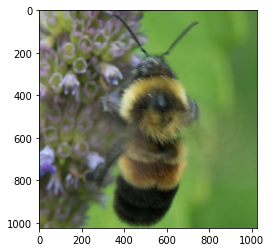

In [12]:
# normal frame
plt.imshow(load_image(path + "affinis_001.jpg"))

In [13]:
# normal frame
#plt.imshow(load_image(path + "0040.jpg"))

In [14]:
# abnormal frame
#plt.imshow(load_image(path_abnormal + "data/0015.jpg"))

In [15]:
# abnormal frame
#plt.imshow(load_image(path_abnormal + "data/0016.jpg"))

In [16]:
train_images = np.array(os.listdir(path))
np.random.shuffle(train_images)
BUFFER_SIZE = 5#200000 # number of images in training i think
BATCH_SIZE = 1#500 # This is just the standard number for batch size. Google for more info
# shuffle and batch the data
np.random.shuffle(train_images)
train_images = np.split(train_images[:BUFFER_SIZE],BATCH_SIZE)

In [17]:
# abnormal_images = np.array(os.listdir(path_abnormal))
# np.random.shuffle(abnormal_images)
# BUFFER_SIZE = 5#200000 # number of images in training i think
# BATCH_SIZE = 1#500 # This is just the standard number for batch size. Google for more info
# # shuffle and batch the data
# np.random.shuffle(abnormal_images)
# abnormal_images = np.split(abnormal_images[:1],BATCH_SIZE)

In [18]:
# x_abnormal_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   path_abnormal,
#   seed=123,
#   image_size=(1024, 1024),
#   batch_size=1)

In [19]:
import tensorflow_datasets as tfds

In [20]:
# for image, label in tfds.as_numpy(x_abnormal_ds):
#   x_abnormal = image

In [21]:
# x_abnormal = x_abnormal.astype('float32') / 255.

In [22]:
# https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn
# In general, having all inputs to a neural network scaled to unit dimensions tries to convert the error surface into a more spherical shape. Hence, Gradient Descent converges faster, reducing training time.

In [23]:
latent_dim = 128
C = 3

In [24]:
## Building the encoder
inputs = layers.Input(shape=(1024, 1024, C), name="inputs")
x = inputs

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

print('shape after encoder: ', x.shape)

x = layers.Flatten()(x)
units = x.shape[1]
x = layers.Dense(latent_dim, name="latent")(x)


## Building the decoder
x = layers.Dense(units)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((256, 256, 32))(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2DTranspose(C, (3,3), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("sigmoid", name="outputs")(x)

outputs = x

shape after encoder:  (None, 256, 256, 32)


In [25]:
print(x.shape)

(None, 1024, 1024, 3)


In [26]:
generator = Model(inputs, outputs)

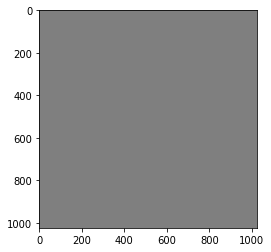

In [27]:
#generator = make_generator_model()

noise = tf.random.normal([1, 1024,1024, 3]) # shape is 1, 100
generated_image = generator(noise, training = False)
#generated_image = generator(x_abnormal, training = False)
#plt.imshow(generated_image[0], interpolation="nearest" )
plt.imshow(generated_image[0])

In [28]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                                     input_shape=[1024, 1024, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
      
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    """
    Flattens the input. Does not affect the batch size.
    If inputs are shaped (batch,) without a channel dimension, then flattening adds an extra channel dimension and output shapes are (batch, 1).
    """
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
     
    return model

In [29]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.0163766]], shape=(1, 1), dtype=float32)


In [30]:
discriminator = make_discriminator_model()
# decision = discriminator(train_images)
# print(decision)

In [31]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

"""
Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predicitions on real images to an array of 1s
and the dicriminator's predicitons on fake (generated) images to an array of 0s.
"""
@tf.function
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  
  return total_loss

"""
Generator Loss

The generator's loss quantifies how well it was able to trick the discrimator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
Here, we will compare the discriminators decisions on the generated images to an array of 1s.
"""
@tf.function
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

"""
The discriminator and the generator optimizers are different since we will train two networks separately.
The Adam optimization algorithm is an extension to stochastic gradient descent.
Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

"""
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [32]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [33]:
checkpoint_prefix

'./training_checkpoints/ckpt'

In [34]:
# We will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF
#tf.random.set_seed(1234)
noise_dim = 100
num_examples_to_generate = 1
#noise = tf.random.normal([1, 1024,1024, 3]) # shape is 1, 100
seed = tf.random.normal([num_examples_to_generate, 1024, 1024, 3], seed=1)
#seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=1)

In [35]:
EPOCHS = 1600

In [36]:
"""
The training loop begins with generator receiving a random seed as input. 
That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). 
The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
"""

# Notice the use of tf.function
# This annotation causes the function to be "compiled"
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # take the image links and return a cropped image
    new_images = []
    for file_name in images:
        new_pic = load_image( path + file_name)
        new_images.append(new_pic)
        #print(new_pic)
    
    images = np.array(new_images)
    images = images.reshape(images.shape[0], 1024, 1024, 3).astype('float32') # puts each number in its own numpy array so instead of [1,2,3] gonna be [[1], [2], [3]]
    images = (images) / 255 # normalize to [0,1]
    


    """
GradientTape() Records operations for automatic differentiation. Operations are recorded if 
they are executed within this context manager and at least one of their inputs is being "watched".
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(seed, training=True)

      real_output = discriminator(images, training=True)
      print(f'real_output: {real_output}')
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # The zip() function returns an iterator of tuples based on the iterable object.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    images = None

In [37]:
# ended at 20 epocsh

In [38]:
#@tf.function
def train(dataset, epochs):  
  tf.print("Starting man!")
  for epoch in range(epochs):
    start = time.time()
    tf.print("Starting Epoch:", epoch)
    batch_count = 1
    for image_batch in dataset:
      #tf.print("Batch:", batch_count)
      train_step(image_batch)
      #print("Batch:", batch_count, "Complete")
      batch_count += 1
    

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    tf.print("Epoch:", epoch, "finished")
    tf.print()
    
    # Save the model every epochs
    #checkpoint.save(file_prefix = checkpoint_prefix)
    
    tf.print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    if epoch % 500 == 0:
       checkpoint.save(file_prefix = checkpoint_prefix)  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [39]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(seed, training=False).numpy()

  #fig = plt.figure(figsize=(15,4))
  
  for i in range(predictions.shape[0]):
      #plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i])
      #plt.axis('off')
      if epoch % 500 == 0:      
         plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [40]:
from IPython.display import Image
#Image(filename='image_at_epoch_0060.png') 

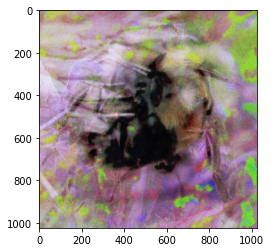

CPU times: user 19min 25s, sys: 4min 31s, total: 23min 56s
Wall time: 28min 16s


In [41]:
%%time
train(train_images, EPOCHS)

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [43]:
!ls ../

bin	 datalab  home	 lib64	opt   run   sys		       tools
boot	 dev	  lib	 media	proc  sbin  tensorflow-1.15.2  usr
content  etc	  lib32  mnt	root  srv   tmp		       var


In [44]:
generator

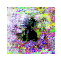

In [45]:
fig = plt.figure(figsize=(4,4))
predictions = checkpoint.generator(seed, training = False).numpy()
for i in range(seed.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i], interpolation="nearest")
    plt.axis('off')
    
plt.show()

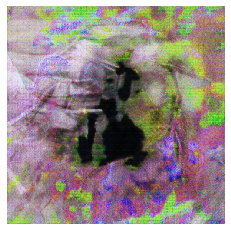

In [46]:
noise = tf.random.normal([1,1024, 1024, 3]) # shape is 1, 100
random_face = checkpoint.generator(noise, training = True).numpy()[0]
plt.imshow(random_face, interpolation='nearest')
plt.axis("off")
plt.show()

In [47]:
random_face.shape

(1024, 1024, 3)

In [48]:
---

SyntaxError: ignored

In [ ]:
%ls

In [ ]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# A hack to display the GIF inside this notebook
os.rename('dcgan.gif', 'dcgan_celebA.gif.png')

In [ ]:
display.Image(filename="dcgan_celebA.gif.png")

In [ ]:
%ls training_checkpoints/

%cp image_at_epoch_0001.png play-with-faces/